# Pytorch Playing Card Classifyer
### This will have 4 steps:
    Setting up a pytorch dataset
    Setting up the pytorch model
    Training the model
    Testing the model

### Importing required dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Creating the dataset class

In [2]:
class PlayingCardsDataSet(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = ImageFolder(root_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

### Creating the pytorch model

In [3]:
class PlayingCardsModel(nn.Module):
    def __init__(self, num_classes=53):
        super(PlayingCardsModel, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

### Training Time

#### Setup datasets

In [4]:
test_dataset = PlayingCardsDataSet(
    root_dir='data/train',
    transform=transforms.Compose([
        transforms.Resize((128, 128)), # Resize the image to 128x128 so that all images have the same size
        transforms.ToTensor()
    ])
)

val_dataset = PlayingCardsDataSet(
    root_dir='data/valid',
    transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
)

train_dataset = PlayingCardsDataSet(
    root_dir='data/train',
    transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

#### Paramaters seting

In [5]:
num_epochs = 7
train_losses, val_losses = [], []
model = PlayingCardsModel(num_classes=53) # Create an instance of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use the GPU if available
print(f"Using device {device}")
model.to(device) # Move the model to the GPU if available
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss is the loss function used for classification problems
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam is the optimizer used to update the weights of the model

Using device cuda


#### Train validate loop

In [6]:
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    train_loss = 0
    for images, labels in tqdm(train_dataloader, desc='Training loop'):
        images, labels = images.to(device), labels.to(device) # Move the images and labels to the GPU if available
        optimizer.zero_grad() # Clear the gradients of all optimized variables
        output = model(images) # Get the model's prediction
        loss = criterion(output, labels) # Calculate the loss
        loss.backward() # Backpropagate the loss
        optimizer.step() # Update the weights
        train_loss += loss.item() * labels.size(0)
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    model.eval() # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item() * labels.size(0)
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/7, Train Loss: 26.1385, Val Loss: 7.1479


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

### Plot learning rate and losses

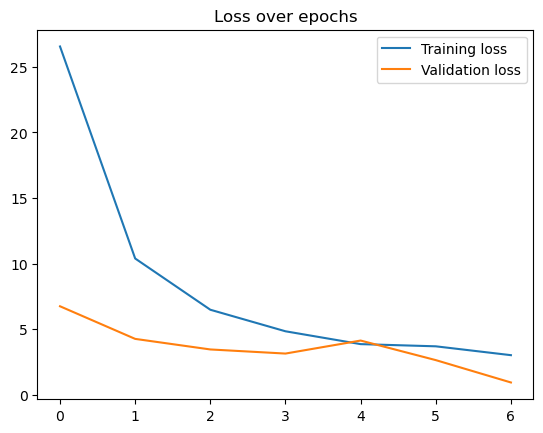

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

### Test model

In [ ]:
model.eval() # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_dataloader, desc='Testing loop'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Testing loop:   0%|          | 0/477 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.37%


### Save model

In [ ]:
torch.save(model.state_dict(), 'trained_model/model.pth')